In [3]:
!pip install seaborn

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
     |████████████████████████████████| 225kB 504kB/s eta 0:00:01
     |████████████████████████████████| 10.1MB 630kB/s eta 0:00:01
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python2.7/dist-packages/pandas-0.24.2.dist-info'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})
import numpy.random
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import signal
import time
import matplotlib.mlab as mlab

ImportError: No module named seaborn

In [393]:
def t_shift(x, n, tau, N, dt):
    # time shift the array x to be x(t-n*tau), and have the right dimension
    
    x_shifted = x[int(n*tau/dt): int(N + n*tau/dt)]

    return x_shifted

def n_X_tdi(n1, n1p, n2p, n3, dur, tau, dt, fs, N):
    # noise that shows up in TDI-X
    
    n1_2t  = t_shift(n1, 2, tau, N, dt)
    n1p_2t = t_shift(n1p, 2, tau, N, dt)
    n2p_3t = t_shift(n2p, 3, tau, N, dt)
    n3_3t = t_shift(n3, 3, tau, N, dt)
    n1     = n1[0:N]
    n1p    = n1p[0:N]
    n2p    = n2p[0:N]
    n3     = n3[0:N]
    
    return (n1 - n1_2t) + (n1p - n1p_2t) + (n2p - n2p_3t) + (n3 - n3_3t)
    

def get_coeffs_X(c1,c1p,c2p_FS,c3_FS,d,e, dur, tau, dt, fs, N):

    t         = np.arange(0, dur+5*tau, dt)


    # Recovered histogram
    c1_rec  = []
    c1p_rec = []
    c2p_FS_rec = []
    c3_FS_rec  = []
    d_rec   = []
    e_rec   = []

    # N different realizations
    for i in range(0,1000):

        mu        = 0.
        sigma_phi = (10e-9)*((fs/2)**0.5)
        phi1    = np.random.normal(mu, sigma_phi, int((dur+5*tau)/dt))
        phi1p   = np.random.normal(mu, sigma_phi, int((dur+5*tau)/dt))
        phi2p   = np.random.normal(mu, sigma_phi, int((dur+5*tau)/dt))
        phi3    = np.random.normal(mu, sigma_phi, int((dur+5*tau)/dt))

        phi1_2t  = t_shift(phi1, 2, tau, N, dt)
        phi1_4t  = t_shift(phi1, 4, tau, N, dt)
        phi1p_2t = t_shift(phi1p, 2, tau, N, dt)
        phi1p_4t = t_shift(phi1p, 4, tau, N, dt)
        phi2p_t  = t_shift(phi2p, 1, tau, N, dt)
        phi2p_3t = t_shift(phi2p, 3, tau, N, dt)
        phi3_t   = t_shift(phi3, 1, tau, N, dt)
        phi3_3t  = t_shift(phi3, 3, tau, N, dt)

        phi1  = phi1[0:N]
        phi1p = phi1p[0:N]
        phi2p = phi2p[0:N]
        phi3  = phi3[0:N]
        
        mu  = 0.
        sigma_n = (10e-12)*((fs/2)**0.5)
        n1  = np.random.normal(mu, sigma_n, int((dur+5*tau)/dt))
        n1p = np.random.normal(mu, sigma_n, int((dur+5*tau)/dt))
        n2p = np.random.normal(mu, sigma_n, int((dur+5*tau)/dt))
        n3  = np.random.normal(mu, sigma_n, int((dur+5*tau)/dt))

        n_shot = n_X_tdi(n1, n1p, n2p, n3, dur, tau, dt, fs, N)

        # Solving for coefficients
        f1 = - phi1 + phi1_2t
        f2 = phi1p - phi1p_2t
        f3 = -phi1_2t + phi1_4t
        f4 = phi1p_2t - phi1p_4t
        f5 = -phi2p_t + phi2p_3t
        f6 = phi3_t - phi3_3t
        
        X = c1*f1 + c1p*f2 + c2p_FS*f3 + c3_FS*f4 + d*f5 + e*f6 + n_shot # data
        
        Omega = np.matrix(np.column_stack((f1,f2,f3,f4,f5,f6))) # Matrix
        Omega_T = np.matrix.transpose(Omega)

        c_vec = np.linalg.inv((Omega_T*Omega)) * np.transpose(np.dot(Omega_T, X))
        c1_rec.append(float(c_vec[0]))
        c1p_rec.append(float(c_vec[1]))
        c2p_FS_rec.append(float(c_vec[2]))
        c3_FS_rec.append(float(c_vec[3]))
        d_rec.append(float(c_vec[4]))
        e_rec.append(float(c_vec[5]))
        
    #return np.array(c1_rec),np.array(c1p_rec),np.array(c2p_FS_rec),np.array(c3_FS_rec),np.array(d_rec),np.array(e_rec)
    return c1_rec,c1p_rec,c2p_FS_rec,c3_FS_rec,d_rec,e_rec
    
def error(x):
    
    # (std.dev/sqrt(N))/mean
    
    return abs(100*np.std(np.array(x))/(np.sqrt(len(x))*np.mean(x)))

def get_np_std(c1_rec,c1p_rec,c2p_FS_rec,c3_FS_rec,d_rec,e_rec):
    import statistics
    
    for i in range(6):
        c1_std     = np.std(c1_rec)
        c1p_std    = np.std(c1p_rec)
        c2p_FS_std = np.std(c2p_FS_rec)
        c3_FS_std  = np.std(c3_FS_rec)
        d_std      = np.std(d_rec)
        e_std      = np.std(e_rec) 
    
    return c1_std,c1p_std,c2p_FS_std,c3_FS_std,d_std,e_std

def get_np_mean(c1_rec,c1p_rec,c2p_FS_rec,c3_FS_rec,d_rec,e_rec):
    
    for i in range(6):
        c1_mean     = np.mean(c1_rec)
        c1p_mean    = np.mean(c1p_rec)
        c2p_FS_mean = np.mean(c2p_FS_rec)
        c3_FS_mean  = np.mean(c3_FS_rec)
        d_mean      = np.mean(d_rec)
        e_mean      = np.mean(e_rec) 
    
    return c1_mean,c1p_mean,c2p_FS_mean,c3_FS_mean,d_mean,e_mean

In [394]:
# Signal parameters

#dur = 600. # 10 mins
dur = 24*3600 # 1 day
tau = 2.5e9/3e8  # time delay along arms
fs  = 10
dt  = 1./fs   # time resolution
N   = int(dur/dt)

In [395]:
# Create TDI-X data and recover using linear regression

time0 = time.time()
# Injection 
c1  = 1.1e-3
c1p = 2.3e-4
c2p_FS = 5e-4
c3_FS  = -3.1e-4
d   = -2.6e-3
e   = 7e-4

c1_rec,c1p_rec,c2p_FS_rec,c3_FS_rec,d_rec,e_rec       = get_coeffs_X(c1,c1p,c2p_FS,c3_FS,d,e, dur, tau, dt, fs, N)
c1_std,c1p_std,c2p_FS_std,c3_FS_std,d_std,e_std       = get_np_std(c1_rec,c1p_rec,c2p_FS_rec,c3_FS_rec,d_rec,e_rec)
c1_mean,c1p_mean,c2p_FS_mean,c3_FS_mean,d_mean,e_mean = get_np_mean(c1_rec,c1p_rec,c2p_FS_rec,c3_FS_rec,d_rec,e_rec)

time1 = time.time()
print((time1-time0)/60,' minutes')

3.908524417877197  minutes


In [391]:
c_inj  = [c1,c1p,c2p,c3,d,e] # Injected values
c_rec  = [c1_rec,c1p_rec,c2p_FS_rec,c3_FS_rec,d_rec,e_rec] # Recovered histograms
c_std  = [c1_std,c1p_std,c2p_FS_std,c3_FS_std,d_std,e_std] # Standard deviations
c_mean = [c1_mean,c1p_mean,c2p_FS_mean,c3_FS_mean,d_mean,e_mean] # Mean values

<ipython-input-392-9491565b34ca>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('32%s' %i)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
<ipython-input-392-9491565b34ca>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('32%s' %i)
/opt/anaconda3/lib/python3.8/s

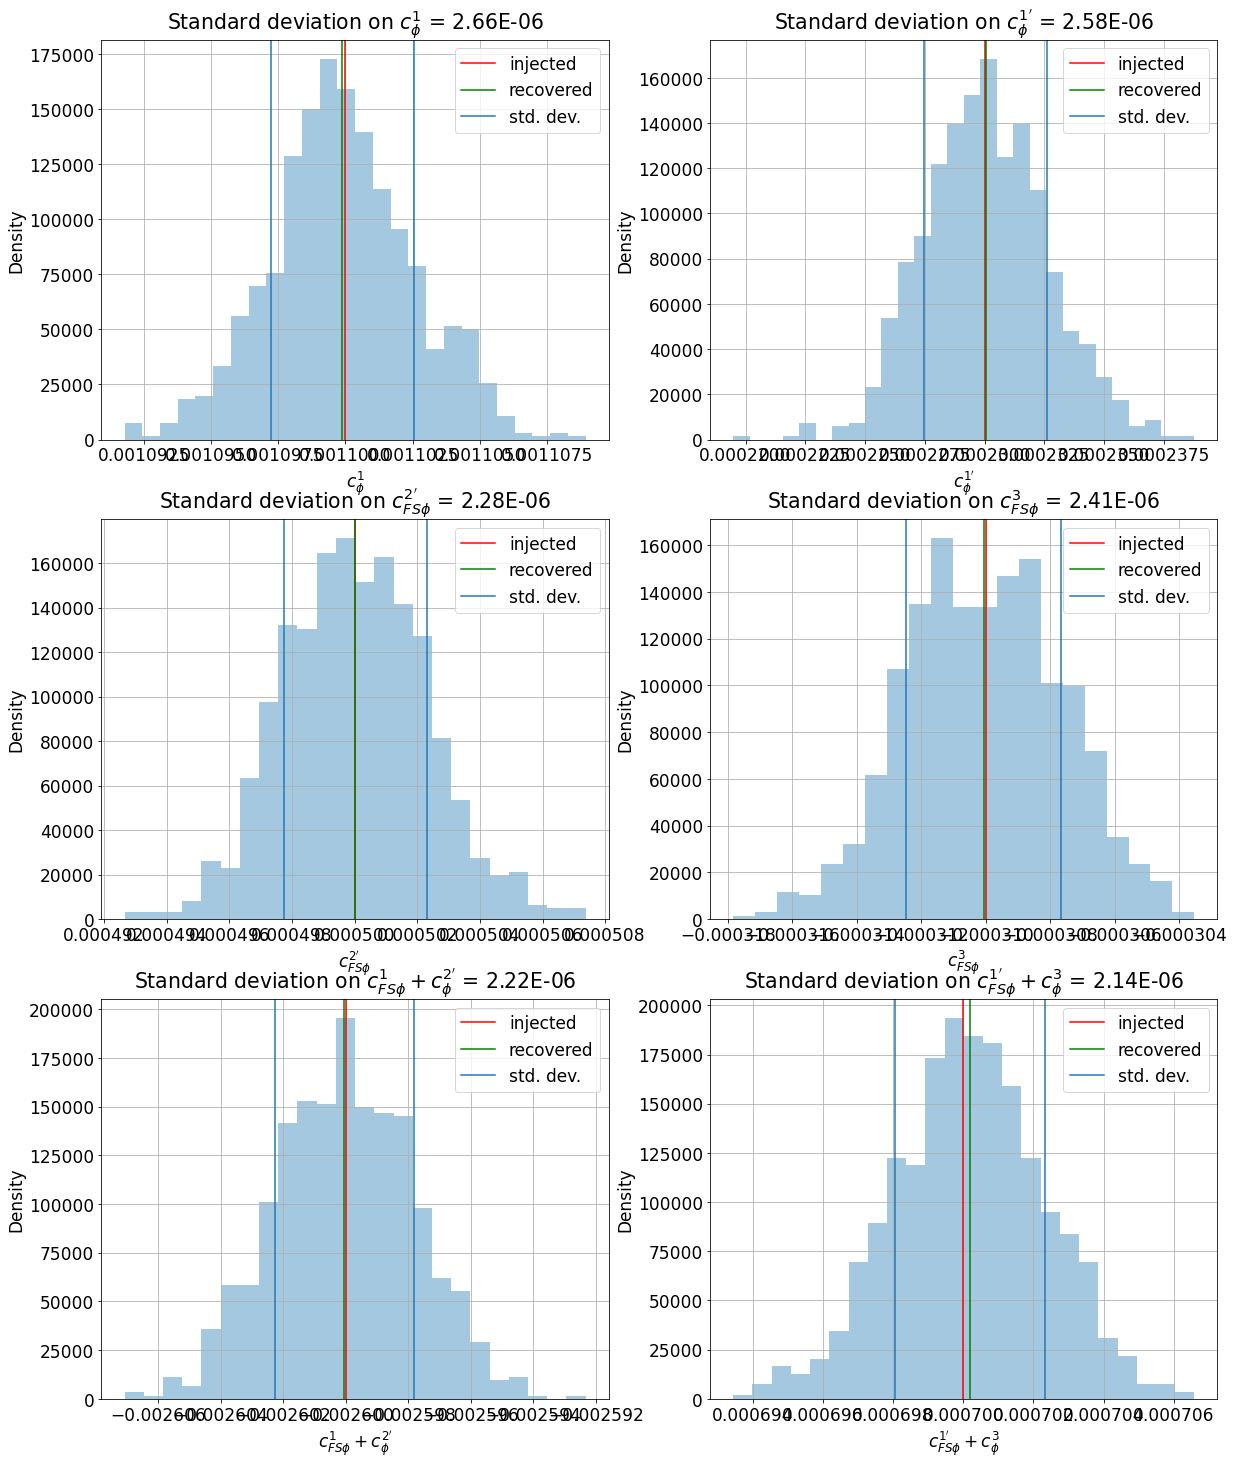

In [392]:
## Plotting recovered distributions using many realizations of the noise

xlabels = ['c_{\\phi}^1', 'c_{\\phi}^{1^{\prime}}', 'c_{FS\\phi}^{2^{\prime}}','c_{FS\\phi}^3', 'c_{FS\\phi}^{1} + c_{\\phi}^{2^{\prime}}', 'c_{FS\\phi}^{1^{\prime}} + c_{\\phi}^{3}']

fig= plt.figure(figsize=(20, 25))
for i in range(6):
    i += 1
    plt.subplot('32%s' %i)
    i -= 1
    plt.title('Standard deviation on $%s$ = %.2E' %(ylabels[i],c_std[i]))
    sns.distplot(c_rec[i],  norm_hist=True)
    plt.axvline(x=c_inj[i], label='injected', c='red')
    plt.axvline(x=c_mean[i], label='recovered', c='green')
    plt.axvline(x=c_mean[i]+c_std[i], label='std. dev.')
    plt.axvline(x=c_mean[i]-c_std[i])
    plt.xlabel('$%s$' %xlabels[i])
    plt.grid()
    plt.legend()
plt.savefig('Figures/Dist_TDI-X_simple-model.pdf', bbox_inches = 'tight', pad_inches = 0)



In [401]:
from IPython.display import HTML, display
import tabulate


table = [["TDI","TTL coeffecient","Injected","Recovered", "Std. dev. "],
         ["X", "$c^1_\\phi$",                                c1,     np.mean(c1_rec),     c_std[0]],
         ["X", "$c^{1 \\prime}_\\phi$",                      c1p,    np.mean(c1p_rec),    c_std[1]],
         ["X", "$c^{2 \\prime}_{FS\\phi}$",                  c2p_FS, np.mean(c2p_FS_rec), c_std[2]],
         ["X", "$c^{3}_{FS\\phi}$",                          c3_FS,  np.mean(c3_FS_rec),  c_std[3]],
         ["X", "$c^{1}_\\phi - c^{1 \\prime}_\\phi$",        d,      np.mean(d_rec),      c_std[4]],
         ["X", "$c^{3}_{FS\\phi} - c^{2\\prime}_{FS\\phi}$", e,      np.mean(e_rec),      c_std[5]]]

display(HTML(tabulate.tabulate(table, tablefmt='html')))


TDI,TTL coeffecient,Injected,Recovered,Std. dev.
X,$c^1_\phi$,0.0011,0.001099932607894689,2.6637552576204152e-06
X,$c^{1 \prime}_\phi$,0.00023,0.00023005967436287534,2.575315229997095e-06
X,$c^{2 \prime}_{FS\phi}$,0.0005,0.0004998981157356298,2.2775709331386253e-06
X,$c^{3}_{FS\phi}$,-0.00031,-0.0003100654422358089,2.4066237419679134e-06
X,$c^{1}_\phi - c^{1 \prime}_\phi$,-0.0026,-0.0025999535462529815,2.2170687727346877e-06
X,$c^{3}_{FS\phi} - c^{2\prime}_{FS\phi}$,0.0007,0.0006999543341762415,2.13794641002107e-06


In [321]:
# Getting TM displacement noise as time-series
from scipy.signal import zpk2sos

f1 = 0.4e-3
f2 = 8.0e-3
#z = [1j*f1, (1+1j)*f2/(2**0.5), -(1+1j)*f2/(2**0.5)]
#p = [0]
#k = 1/((2*np.pi)**2)
#sos = zpk2sos(z, p, k)

z=[1,2]
p=[0,3]
k=1
sos= zpk2sos(z, p, k)
print(sos)

#sos = [[1,0,f1**2,0,f2**4,0,(f1**2)*(f2**4),0,0,f2**2,0,0,0,0]] # true SOS? but not working with library
sos = [[1,0,f1**2,0,0,1]]

mu  = 0.
sigma_TM = (2.4e-15)*((fs/2)**0.5)
TM_noise = np.random.normal(mu, sigma_TM, 10000)

[[ 1. -3.  2.  1. -3.  0.]]


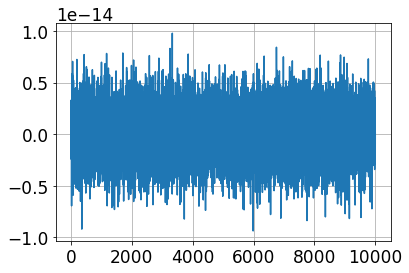

In [322]:
plt.plot(TM_noise)
plt.grid()

In [323]:
colored_TM_noise = signal.sosfiltfilt(sos, TM_noise)
print(colored_TM_noise)
plt.plot(colored_TM_noise)
plt.grid()

ValueError: sos[:, 3] should be all ones

In [313]:
## mlab

wrange = 0.5e5 # window size
wrange = 10000000
S_TM, freqs = mlab.psd(TM_noise, Fs = fs)
S_TM_colored, freqs = mlab.psd(colored_TM_noise, Fs = fs)
S_TM_colored, freqs = mlab.psd(colored_TM_noise, Fs = fs)#, NFFT = int(wrange*fs))

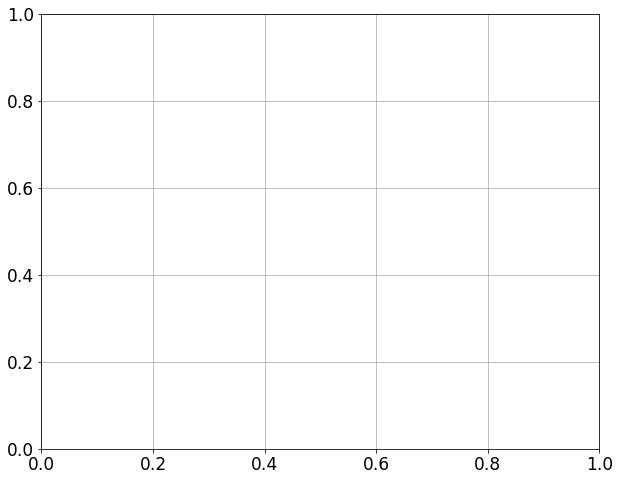

In [269]:
plt.figure(figsize=(10, 8))
#plt.loglog(freqs, S_TM**0.5)
#plt.ylim([1e-16,1e-10])
#plt.loglog(freqs, S_TM_colored**0.5)
plt.grid()

-1.9910369803898786


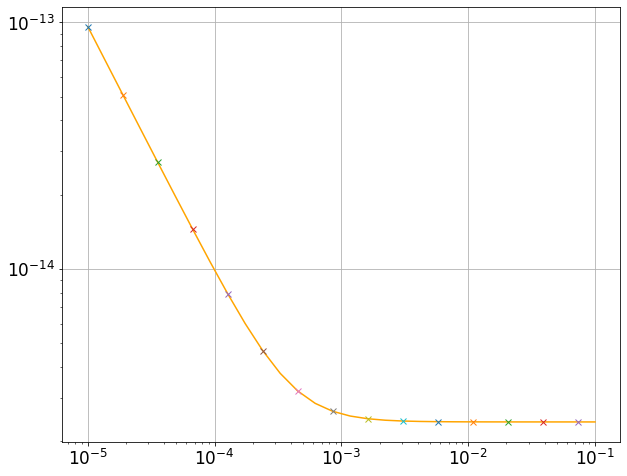

In [291]:
freqs = np.logspace(-5,-1,30)
test  = ((2.4e-15)**2)
test *= (1+(f1/freqs)**2)
#test *= (1+(freqs/f2)**4)
#test /= ((2*np.pi*freqs)**4)

plt.figure(figsize=(10, 8))
plt.loglog(freqs, test**0.5, c='orange')
for i in range(int(len(freqs)/2)):
    i *= 2
    plt.loglog(freqs[i], test[i]**0.5, marker='x')
#plt.axvline(x=f1)
#plt.axvline(x=f2)
plt.grid()

print((np.log10(test[5]) - np.log10(test[0]))/(np.log10(freqs[5]) - np.log10(freqs[0])))

In [397]:
import statistics

c1_std2 = np.std(c1_rec)
c1_std  = abs(np.std(np.array(c1_rec))/(np.sqrt(len(c1_rec))*np.mean(c1_rec)))

print(c1_std, c1_std2)

7.756536297016419e-05 2.697950058235179e-06
